In [303]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from vtk_visualizer import *

label_path = '/media/andy/Storage/Challenge/kitti_object/data_object_image_2/training/label_2/'
image_path = '/media/andy/Storage/Challenge/kitti_object/data_object_image_2/training/image_2/'
lidar_path = '/media/andy/Storage/Challenge/kitti_object/data_object_velodyne/training/velodyne/'
calib_path = '/media/andy/Storage/Challenge/kitti_object/data_object_calib/training/calib/'

dataset = [name.split('.')[0] for name in os.listdir(label_path)]

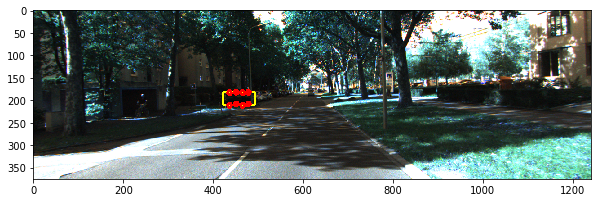

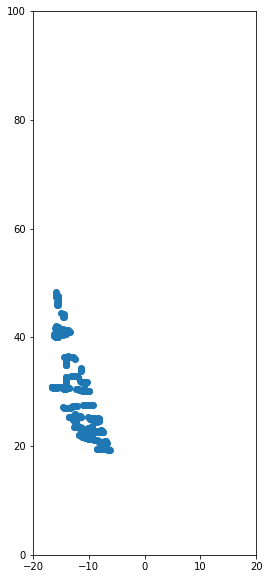

In [307]:
index = np.random.randint(len(dataset))

# read calibration data
for line in open(calib_path + dataset[index] + '.txt').readlines():
    if 'P2:' in line:
        cam_to_img = line.strip().split(' ')
        cam_to_img = np.asarray([float(number) for number in cam_to_img[1:]])
        cam_to_img = np.reshape(cam_to_img, (3,4))
        
    if 'R0_rect:' in line:
        R0_rect = line.strip().split(' ')
        R0_rect = np.asarray([float(number) for number in R0_rect[1:]])
        R0_rect = np.reshape(R0_rect, (3,3))
        
    if 'Tr_velo_to_cam:' in line:
        Tr_velo_to_cam = line.strip().split(' ')
        Tr_velo_to_cam = np.asarray([float(number) for number in Tr_velo_to_cam[1:]])
        Tr_velo_to_cam = np.reshape(Tr_velo_to_cam, (3,4))
        
R0_rect = np.append(R0_rect, np.zeros((3,1)), axis=1)
R0_rect = np.append(R0_rect, np.zeros((1,4)), axis=0)
R0_rect[-1,-1] = 1

Tr_velo_to_cam = np.append(Tr_velo_to_cam, np.zeros((1,4)), axis=0)
Tr_velo_to_cam[-1,-1] = 1

# draw 2D boxes and 3D boxes
image = cv2.imread(image_path + dataset[index] + '.png')
cars = []

for line in open(label_path + dataset[index] + '.txt').readlines():
    line = line.strip().split(' ')
    
    if 'Car' in line[0]:
        cars.append([x_min, x_max, y_min, y_max])
        
        # Draw 2D Bounding Box
        x_min, y_min, x_max, y_max = [int(float(number)) for number in line[4:8]]
        cv2.rectangle(image, (x_min,y_min), (x_max,y_max), (255,255,0), 3)

        # Draw 3D Bounding Box
        dims   = np.asarray([float(number) for number in line[8:11]])
        center = np.asarray([float(number) for number in line[11:14]])

        for i in [-1,1]:
            for j in [-1,1]:
                for k in [0,1]:
                    point = np.copy(center)
                    point[0] = center[0] + i * dims[1]/2
                    point[2] = center[2] + j * dims[2]/2
                    point[1] = center[1] - k * dims[0]

                    point = np.append(point, 1)
                    point = np.dot(cam_to_img, point)
                    point = point[:2]/point[2]
                    point = point.astype(np.int16)

                    cv2.circle(image, (point[0],point[1]), 4, (255,0,0), 5)
                    
        break

fig = plt.figure(figsize=(10,10))
plt.imshow(image); plt.show()

# draw LIDAR data
point_cloud = np.fromfile(lidar_path + dataset[index] + '.bin', dtype='float32')
point_cloud = np.reshape(point_cloud, (-1,4))

inclusion = []

for index in xrange(point_cloud.shape[0]):
    point = np.append(point_cloud[index,:3], 1)
    
    if point[0] > 0:
        # to image coordinates
        trans = np.dot(cam_to_img, R0_rect)
        trans = np.dot(trans, Tr_velo_to_cam)
        point = np.dot(trans, point)

        point = point[:2]/point[2]
        point = point.astype(np.int16)

        # check for inclusion
        for car in cars:
            if car[0] < point[0] < car[1] and car[2] < point[1] < car[3]:
                inclusion.append(index)
                
plt.figure(figsize=(4,10))                
plt.scatter(-point_cloud[inclusion,1],point_cloud[inclusion,0])
plt.xlim(-20, 20)
plt.ylim(0, 100)
plt.show()